In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Lets the notebook transition to R  easily!
%load_ext rpy2.ipython

#importing ODElib for this demo
import os, sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import ODElib
from ODElib.distributions import Positive_Normal

#profiler for code
%load_ext snakeviz

#too many warning crash the notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
#sys.path.append("/home/spiridon/Research/growth_curves/src")
#from ModelFrameworks import SnI

In [3]:
# the models

# zero infected classes
def zero_i(y,t,ps):
    mu,phi,beta=ps[0],ps[1],ps[2]
    S,V = y[0],y[1]
    dSdt = mu*S - phi*S*V
    dVdt = beta*phi*S*V - phi*S*V
    return [dSdt,dVdt]

# one infected classes
def one_i(y,t,ps):
    mu,phi,beta,lam=ps[0],ps[1],ps[2],ps[3]
    S,I1,V = y[0],y[1],y[2]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - lam*I1
    dVdt = beta*lam*I1 - phi*S*V
    return np.array([dSdt,dI1dt,dVdt])

# two infected classes
def two_i(y,t,ps):
    mu,phi,beta,lam,tau1=ps[0],ps[1],ps[2],ps[3],ps[4]
    S,I1,I2,V = y[0],y[1],y[2],y[3]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - I1/tau1
    dI2dt = I1/tau1 - lam*I2
    dVdt = beta*lam*I2 - phi*S*V
    return np.array([dSdt,dI1dt,dI2dt,dVdt])

# three infected classes
def three_i(y,t,ps):
    mu,phi,beta,tau1,tau2,lam=ps[0],ps[1],ps[2],ps[3],ps[4],ps[5]
    S,I1,I2,I3,V = y[0],y[1],y[2],y[3],y[4]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - I1/tau1
    dI2dt = I1/tau1 - I2/tau2
    dI3dt = I2/tau2 - lam*I3
    dVdt = beta*lam*I3 - phi*S*V
    return np.array([dSdt,dI1dt,dI2dt,dI3dt,dVdt])

# four infected classes
def four_i(y,t,ps):
    mu,phi,beta,lam,tau1,tau2,tau3=ps[0],ps[1],ps[2],ps[3],ps[4],ps[5],ps[6]
    S,I1,I2,I3,I4,V = y[0],y[1],y[2],y[3],y[4],y[5]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - I1/tau1
    dI2dt = I1/tau1 - I2/tau2
    dI3dt = I2/tau2 - I3/tau3
    dI4dt = I3/tau3 - lam*I4
    dVdt = beta*lam*I4 - phi*S*V
    return np.array([dSdt,dI1dt,dI2dt,dI3dt,dI4dt,dVdt])

# five infected classes
def five_i(y,t,ps):
    mu,phi,beta,lam,tau1,tau2,tau3,tau4=ps[0],ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7]
    S,I1,I2,I3,I4,I5,V = y[0],y[1],y[2],y[3],y[4],y[5],y[6]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - I1/tau1
    dI2dt = I1/tau1 - I2/tau2
    dI3dt = I2/tau2 - I3/tau3
    dI4dt = I3/tau3 - I4/tau4
    dI5dt = I4/tau4 - lam*I5
    dVdt = beta*lam*I5 - phi*S*V
    return np.array([dSdt,dI1dt,dI2dt,dI3dt,dI4dt,dI5dt,dVdt])

In [4]:
df = pd.read_csv("testdat.csv")
df.set_index('organism',inplace=True)
df_framework=df.rename({'uncertainty':'sigma'},axis=1)
df_framework.rename({'virus':'V','host':'S'},inplace=True)


In [5]:
#For demonstration puposes, lets start off with zero infected classes

zeroI=ODElib.ModelFramework(ODE=zero_i,
                          parameter_names=['mu','phi','beta'],
                          state_names = ['S','V'],
                          dataframe=df_framework,
                          mu = 1e-06,
                          phi = 1e-08,
                          beta = 25,t_steps=288
                         )
zeroI

Current Model = __main__.zero_i
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 25
Initial States:
	S = 5236899.999999998
	V = 10980999.999999985

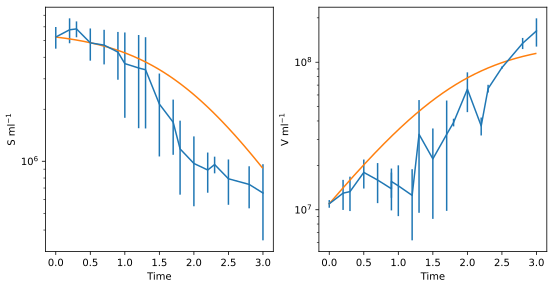

In [6]:
f,ax=zeroI.plot()

In [7]:
trans = lambda d : np.power(10,-d)
priors = {'mu':(Positive_Normal(6,3),trans),
          'phi':(Positive_Normal(8,4),trans)
          #'beta':(Positive_Normal(30,15),None),
         }

mu_prior = (6,3,True) # mean: 10^-6, mean - std: 10^-10, mean + std: 10^-2
phi_prior = (8,4,True)
beta_prior = (30,15,False)# normal distribution, mean = 30, sigma = 15.


fits=zeroI.search_initparamfits(samples=1000,
                                cpu_cores=4,
                                **priors)
fits['chi'].describe()

Sampling with a Latin Hypercube scheme
Starting 4 processes with 4 cores	[DONE]


count       630.000000
mean      14342.140982
std       85368.550037
min          19.846909
25%         135.348668
50%         152.588965
75%         152.826621
max      800705.358700
Name: chi, dtype: float64

In [8]:
goodfits=fits[fits['chi'] < 200]
MCMC_inits = goodfits[zeroI.get_pnames()].sample(16)
MCMC_inits

,mu,phi,beta
433,4.854294e-11,8.469703e-15,25.0
192,2.809914e-02,4.837479e-12,25.0
881,2.856019e-05,5.887047e-10,25.0
115,5.537300e-05,2.780725e-11,25.0
870,1.227439e-06,2.240847e-18,25.0
179,1.555762e-10,1.563721e-13,25.0
703,7.776096e-07,5.164225e-15,25.0
871,6.825856e-06,3.588409e-11,25.0
724,2.403479e-08,6.743798e-16,25.0
77,4.079193e-04,3.380263e-09,25.0


In [ ]:
posteriors = zeroI.MCMC(chain_inits = MCMC_inits,
                        iterations=1000,
                        cpu_cores=4,
                        static_parameters=['beta'])
posteriors

In [ ]:
pnames = zeroI.get_pnames()
dim = len(pnames)
f,ax = plt.subplots(dim,figsize=[dim*2,dim*4])
ax = ax.flatten()
for (a,p,i) in zip(ax,pnames,range(len(pnames))):
    a.hist(np.log(posteriors[p]),30,density=True)
    a.set_xlabel('log('+p+')')
    a.set_ylabel('Probability density')
f.suptitle('Posterior distributions')
f.subplots_adjust(hspace=0.25,wspace=0.25)  

In [ ]:
best_chi=posteriors[posteriors['chi']==posteriors['chi'].min()].iloc[0]
zeroI.set_parameters(**best_chi[['mu','phi','beta']].to_dict())
best_chi

In [ ]:
f,ax=zeroI.plot()